In [1]:
import numpy as np
#cimport numpy as np
import h5py
import matplotlib.pyplot as plt
import MSMRD.trajectories.trajectoryTools as trajTools
%matplotlib inline

In [2]:
%%time
numfiles = 51
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/box/2DasymTrajsLong_B6_RT1E7_dt001_SI10'
samplingInterval = 10
dimension = 2
minima = np.array([[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]])
discretizer = trajTools.trajDiscretizationCython(minima, 2.5)
trajs = []
fullDTrajs = []
truncTrajs = []
dTruncTrajs = []
i = 0
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], samplingInterval):
        print 'timestep not constant'
    traj = data[::1,1:dimension+1]
    fullDTrajs.append(discretizer.getdTrajs([traj]))
    lastTruncTrajs = discretizer.getTruncatedTraj(traj, prepend=True)
    truncTrajs += lastTruncTrajs
    dTruncTrajs += discretizer.getdTrajs(lastTruncTrajs)
    i+=1
    if i % 10 == 0:
        print str(i/float(numfiles) * 100)+'% done'
    # delete memory to avoid overhead
    del data
    del traj

19.6078431373% done
39.2156862745% done
58.8235294118% done
78.431372549% done
98.0392156863% done
CPU times: user 12min 25s, sys: 904 ms, total: 12min 26s
Wall time: 12min 45s


In [113]:
fname1 = '../data/asym2D/box/2DasymTrajsLong_B6_RT1E7_dt001_SI10'
fname2 = '../data/asym2D/ring/rerun/2Dasym_Ring4_RT1e7_TS1e-4_SI10_SF2.0_'
MSMradius = 2.0
numfiles1 = 51
numfiles2 = 31
X = np.arange(-MSMradius, MSMradius, 0.01)
Y = np.arange(-MSMradius, MSMradius, 0.01)
Zfull1 = np.zeros([X.shape[0]-1, X.shape[0]-1])
Zfull2 = np.zeros([X.shape[0]-1, X.shape[0]-1])
for number in range(numfiles1):
    f = h5py.File(fname1 + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    traj = data[:,1:3]
    #bath = np.where(np.linalg.norm(traj, axis=1) > 3.0)[0] 
    hist = np.histogram2d(traj[:,1], traj[:,0], bins = [X, Y], normed=False)
    Zfull1 += hist[0]

for number in range(numfiles2):
    f = h5py.File(fname2 + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    traj = data[:,1:3]
    #bath = np.where(np.linalg.norm(traj, axis=1) > 3.0)[0] 
    hist = np.histogram2d(traj[:,1], traj[:,0], bins = [X, Y], normed=False)
    Zfull2 += hist[0]

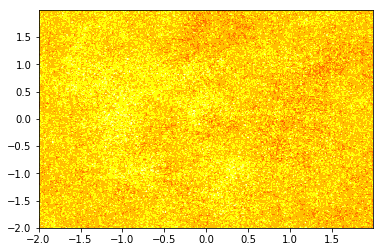

In [119]:
Znormed1 = Zfull1/np.sum(Zfull1)
Znormed2 = Zfull2/np.sum(Zfull2)
extent = [X[0], X[-1], Y[0], Y[-1]]
cp = plt.contourf(Znormed1 - Znormed2, 10, cmap=plt.cm.hot, extent=extent)

In [3]:
%%time
entryTrajsStart, entryTrajsEnd, entryTimes = discretizer.getLookupTableEntry(dTruncTrajs, truncTrajs)

CPU times: user 11.3 s, sys: 60 ms, total: 11.4 s
Wall time: 11.4 s


In [4]:
%%time
exitPositions, exitTimes = discretizer.getLookupTableExit(dTruncTrajs, truncTrajs)

CPU times: user 5.81 s, sys: 8 ms, total: 5.82 s
Wall time: 5.81 s


In [5]:
%%time
transitionTrajs = discretizer.getTransitionTrajs(dTruncTrajs)

CPU times: user 8.21 s, sys: 36 ms, total: 8.25 s
Wall time: 8.24 s


247
281
335
319
326
278
304
299
358


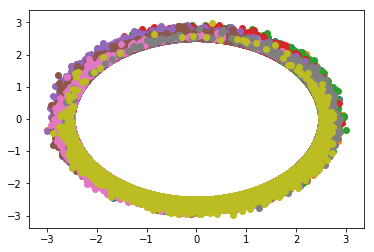

In [93]:
for i in range(9):
    plt.scatter(np.array(exitPositions[i])[:,0], np.array(exitPositions[i])[:,1])
for i in range(9):
    print np.sort(exitTimes[i])

In [108]:
np.random.choice(500)

66

In [8]:
print len(dTruncTrajs)
print len(truncTrajs)

1150635
1150635


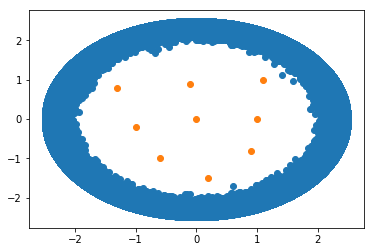

In [7]:
plt.scatter(entryTrajsStart[:,0], entryTrajsStart[:,1])
plt.scatter(minima[:,0], minima[:,1])

In [7]:
angles = np.arctan2(entryTrajsStart[:,1], entryTrajsStart[:,0]) + np.pi
NangularPartitions = 60
angularMap = []
sortedEntryTrajsStart = []
sortedEntryTrajsEnd = []
sortedEntryTimes = []
for i in range(NangularPartitions):
    angularIncrement = 2*np.pi/NangularPartitions
    idcs = np.where(np.logical_and(angles>i*angularIncrement, angles<= (i+1)*angularIncrement))[0]
    sortedEntryTrajsStart.append(entryTrajsStart[idcs])
    sortedEntryTimes.append(entryTimes[idcs])
    sortedEnds = []
    for j in idcs:
        sortedEnds.append(entryTrajsEnd[j])
    sortedEntryTrajsEnd.append(sortedEnds)

In [8]:
exitProbs = np.zeros(9)
for i in range(9):
    outgoingTrajs = 0
    for j in range(10):
        outgoingTrajs += len(transitionTrajs[i][j])   
    exitProbs[i] = len(transitionTrajs[i][9])/float(outgoingTrajs)
print exitProbs

[ 0.04707718  0.20058453  0.4954896   0.25011928  0.51546322  0.23568394
  0.27641693  0.28140222  0.42587279]


In [21]:
#resolve problem that fullDTrajs is a list of lists
trajectories = []
for traj in fullDTrajs:
    trajectories.append(traj[0])

In [25]:
import pyemma
import pyemma.plots as mplt
its = pyemma.msm.its(trajectories,  lags = 50, reversible=True)

(array([ -20.,    0.,   20.,   40.,   60.,   80.,  100.,  120.]),
 <a list of 8 Text yticklabel objects>)

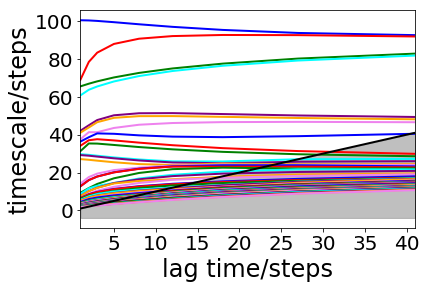

In [26]:
# Plot implied time scales
mplt.plot_implied_timescales(its, ylog=False, units='steps', linewidth=2, dt=1)
plt.ylabel(r"timescale/steps", fontsize = 24)
plt.xlabel(r"lag time/steps", fontsize = 24)
#plt.xlim(0,900)
#plt.ylim(-100,1700)
#plt.xlim(0,100)
#plt.ylim(100,10000)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [56]:
MSMlag = 10
M = pyemma.msm.estimate_markov_model(trajectories, lag=MSMlag)

In [57]:
# truncate transition matrix such that only transitions withing the inner states are allowed
Tmatrix= np.copy(M.transition_matrix[:9,:9])
for i in range(9):
    Tmatrix[i,:] /= np.sum(Tmatrix[i,:])

In [58]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class truncTrajsModel(object):    
    def __init__(self, entryTrajsStart, entryTrajsEnd, entryTimes, exitTrajs, exitTimes, exitProbs, MSMtime, tmatrix, NangularBins):
        self.entryTrajsStart = entryTrajsStart
        self.entryTrajsEnd = entryTrajsEnd
        self.entryTimes = entryTimes
        self.exitTrajs = exitTrajs
        self.exitTimes = exitTimes
        self.exitProbs = exitProbs
        self.tmatrix = tmatrix
        self.MSMtimestep = MSMtime
        self.NangularBins = NangularBins

In [59]:
model = truncTrajsModel(sortedEntryTrajsStart, sortedEntryTrajsEnd, sortedEntryTimes, exitPositions, exitTimes, exitProbs, 0.1, Tmatrix, NangularPartitions)

In [60]:
import pickle
pickle.dump(model, open('../data/models/asym2D/periodicModel_lag10_60partitions.p', 'wa'))

In [61]:
#check MFPTS to the bath state
Nstates = M.transition_matrix.shape[0]
bathStates = range(Nstates - discretizer.angularPartitions*discretizer.bathRings, Nstates)

In [19]:
M.mfpt(8, bathStates)*0.01

NameError: name 'bathStates' is not defined

In [74]:
modelJoinedTrajs = pickle.load(open('../data/models/asym2D/truncatedTrajs_lag5_sorted.p', 'r'))

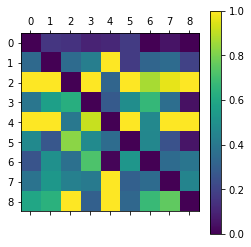

In [23]:
plt.matshow((modelJoinedTrajs.tmatrix - model.tmatrix)/model.tmatrix)
plt.clim(0,1)
plt.colorbar()

In [94]:
print exitProbs

[ 0.04707718  0.20058453  0.4954896   0.25011928  0.51546322  0.23568394
  0.27641693  0.28140222  0.42587279]


In [42]:
entryTrajs = [i for i in sortedEntryTrajsEnd[1:4]]

In [43]:
entryTrajs

[[array([-2.62883663, -0.47379422]),
  array([-2.69385028, -0.13087198]),
  array([-2.60894918, -0.14644063]),
  array([-2.68375397,  0.01177431]),
  array([-2.46302772, -0.59944868]),
  array([-2.42463565, -0.7440905 ]),
  array([-2.53834128, -0.56485629]),
  array([-2.47887301, -0.38458157]),
  array([-2.59824729, -0.28034019]),
  array([-2.50451899, -0.48773128]),
  array([-2.56388831, -0.48814663]),
  array([-2.47537041, -0.7206015 ]),
  array([-2.53634739, -0.66457951]),
  array([-2.60005927, -0.24251394]),
  array([-2.55144644, -0.01585375]),
  array([-2.74130702, -0.36648965]),
  array([-2.51042318, -0.14659849]),
  array([-2.49405336, -0.47513896]),
  array([-2.57623625, -0.71040207]),
  array([-2.53269863, -0.28896737]),
  0,
  array([-2.47788835, -0.75845879]),
  5,
  array([-2.56649876, -0.22136164]),
  array([-2.48619127, -0.28144395]),
  array([-2.51072669, -0.25899661]),
  array([-2.60994196, -0.11266766]),
  array([-2.50941682, -0.26282099]),
  array([-2.37702703, -0.841

In [ ]:
for sets in sortedEntryTrajsEnd:
    for traj in sets:
        if isinstance(traj, np.ndarray):
            plt.scatter(traj[0], traj[1])

In [49]:
print len(sortedEntryTrajsEnd)

60


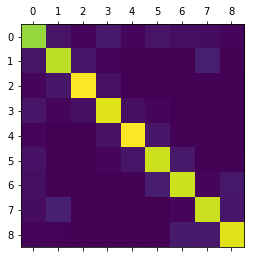

In [63]:
plt.matshow(Tmatrix)

In [65]:
smallModel=pyemma.msm.markov_model(Tmatrix)

In [67]:
smallModel.eigenvectors_left()

array([[ 0.11172267,  0.11257772,  0.10931426,  0.12482063,  0.10694395,
         0.11662167,  0.10922811,  0.10866014,  0.10011084],
       [ 0.00029236, -0.11615524, -0.12144681,  0.04494583,  0.21439635,
         0.12616289,  0.02667375, -0.11356559, -0.06130354],
       [-0.0056852 , -0.04185499, -0.18700026, -0.12590449, -0.05864163,
         0.0478664 ,  0.13762945,  0.07019161,  0.16339912],
       [ 0.00777992, -0.09892648,  0.1305232 ,  0.01635361, -0.14341942,
         0.10331858,  0.15283957, -0.16703987, -0.00142911],
       [ 0.10903997,  0.01135681, -0.15950576,  0.23515071, -0.13898677,
         0.00372738, -0.01090733,  0.0086096 , -0.05848463],
       [-0.05018627, -0.12518763,  0.0296646 ,  0.15051401,  0.04531809,
        -0.15960117, -0.02942853, -0.05494379,  0.19385071],
       [-0.00350516, -0.09672951,  0.03293983, -0.00114562, -0.06095862,
         0.20420555, -0.21354672,  0.0563418 ,  0.08239846],
       [ 0.13015664,  0.15933287, -0.04119623, -0.06796118,  0

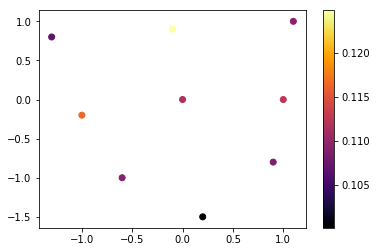

In [86]:
eig1 = smallModel.eigenvectors_left()[0]
plt.scatter(minima[:,0], minima[:,1], c=eig1, cmap=plt.cm.inferno)
plt.colorbar()

In [75]:
gluedTrajsModel = pyemma.msm.markov_model(modelJoinedTrajs.tmatrix)

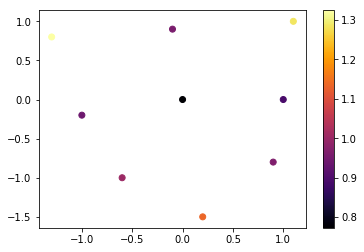

In [88]:
eig2 = gluedTrajsModel.eigenvectors_left()[0]
plt.scatter(minima[:,0], minima[:,1], c=eig1/eig2, cmap=plt.cm.inferno)
plt.colorbar()